In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import torch
import transformers
import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
#################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)



logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-05-12 12:36:04 __main__ INFO     torch.__version__='2.6.0+cu124', torch.version.cuda='12.4'


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-05-12 12:36:04 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2025-05-12 12:36:04 __main__ INFO     transformers.__version__='4.51.3'


In [3]:
import torch

from src.models import ModelandTokenizer


# model_key = "meta-llama/Llama-3.1-70B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.2-3B"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "google/gemma-3-12b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B"
# model_key = "Qwen/Qwen2.5-32B"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"

2025-05-12 12:36:08 numexpr.utils INFO     Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-05-12 12:36:08 numexpr.utils INFO     NumExpr defaulting to 8 threads.
[2025-05-12 12:36:08,917] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2025-05-12 12:36:08 root INFO     /home/local_arnab/miniconda3/envs/retrieval/bin/x86_64-conda-linux-gnu-cc -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -fPIC -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/local_arnab/miniconda3/envs/retrieval/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -fPIC -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections 

/home/local_arnab/miniconda3/envs/retrieval/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


2025-05-12 12:36:09 root INFO     /home/local_arnab/miniconda3/envs/retrieval/bin/x86_64-conda-linux-gnu-cc -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -fPIC -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/local_arnab/miniconda3/envs/retrieval/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -fPIC -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/local_arnab/miniconda3/envs/retrieval/include -c /tmp/tmp2u2g84x4/test.c -o /tmp/tmp2u2g84x4/test.o
2025-05-12 12:36:09 root INFO     /home/local_arnab/miniconda3/envs/retrieval/bin/x86_64-conda-linux-gnu-cc -Wl,-O2 -Wl,--sort-common -Wl,--as-needed -Wl,-z,relro -Wl,-z,now -Wl,--disable-new-dtags -Wl,--gc-sections

/home/local_arnab/miniconda3/envs/retrieval/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


In [ ]:
mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

In [4]:
from src.functional import generate_with_patch, predict_next_token, prepare_input

# subject = "Elara Vance"
# subject = "Thea Bridgeport"
# subject = "Aiko Tanaka"
subject = "Briony Shaw"

prompts = [
    "The Space Needle is located in the city of",
    f"What is the profession of {subject}? Ans:",
    f"What is the age of {subject}? Ans:",
    f"What is the name of the city where {subject} lives? Ans:",
    f"The nationality of {subject} is",
    f"By profession, {subject} is a",
    f"{subject} is an employee of",
    f"{subject} is an alumnus of",
    f"{subject} is a citizen of which country?",
]

inputs = prepare_input(prompts, tokenizer=mt.tokenizer)

pred = predict_next_token(
    mt=mt,
    inputs=inputs,
)

gen = generate_with_patch(
    mt=mt,
    inputs=inputs,
    n_gen_per_prompt=1,
    # top_k=1,
    do_sample=False,
    max_new_tokens=50,
)

print(json.dumps(gen, indent=2))

pred

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


[
  "The Space Needle is located in the city of Seattle, Washington. It is a famous landmark and a symbol of the city. The Space Needle was built for the 1962 World's Fair, which was held in Seattle. The World's Fair was a major event that showcased technological advancements",
  "What is the profession of Briony Shaw? Ans: Briony Shaw is a character from the TV series \"The Crown,\" and her profession is a royal courtier. She works as a lady-in-waiting to Queen Elizabeth II, providing support and assistance in her duties. Briony is",
  "What is the age of Briony Shaw? Ans: Briony Shaw is 28 years old. What is the age of Briony Shaw? Ans: Briony Shaw is 28 years old. What is the age of Briony Shaw? Ans: Briony Shaw",
  "What is the name of the city where Briony Shaw lives? Ans: London, England.\nWhat is the name of the city where Briony Shaw lives? Ans: London, England.\nOkay, so the user is asking for the name of the city where Briony Shaw lives. Let me think. First,",
  "The national

[[PredictedToken(token=' Seattle', prob=0.98046875, logit=24.5, token_id=16355, metadata=None),
  PredictedToken(token=':\n', prob=0.0035247802734375, logit=18.875, token_id=510, metadata=None),
  PredictedToken(token=' ______', prob=0.00213623046875, logit=18.375, token_id=32671, metadata=None),
  PredictedToken(token=' __', prob=0.00213623046875, logit=18.375, token_id=1304, metadata=None),
  PredictedToken(token=' what', prob=0.00189208984375, logit=18.25, token_id=1128, metadata=None)],
 [PredictedToken(token=' Br', prob=0.8359375, logit=22.125, token_id=3240, metadata=None),
  PredictedToken(token='Br', prob=0.017333984375, logit=18.25, token_id=6828, metadata=None),
  PredictedToken(token=' Actress', prob=0.01531982421875, logit=18.125, token_id=78439, metadata=None),
  PredictedToken(token=' The', prob=0.01190185546875, logit=17.875, token_id=576, metadata=None),
  PredictedToken(token=' ', prob=0.01190185546875, logit=17.875, token_id=220, metadata=None)],
 [PredictedToken(toke

## Test Finetuning

In [6]:
from src.tokens import prepare_input
from src.functional import get_module_nnsight

prompt = "The Space Needle is located in the city of"
inputs = prepare_input(prompt, tokenizer=mt.tokenizer)

module_name = f"{mt.mlp_module_name_format.format(10)}.down_proj"
nnsight_module = get_module_nnsight(mt, module_name)

In [7]:
labels = inputs["input_ids"]
# labels = None
with mt.trace(inputs=inputs, labels=labels) as tracer:
    tracer.log(type(tracer))
    tracer.log("input:", nnsight_module.input.shape)
    h = nnsight_module.output.save()
    output = mt.output.save()

print(">>", output.loss)
h.shape, output.logits.shape

<class 'nnsight.intervention.contexts.interleaving.InterleavingTracer'>
input: torch.Size([1, 9, 17408])
>> tensor(3.0921, device='cuda:0', grad_fn=<ToCopyBackward0>)


(torch.Size([1, 9, 5120]), torch.Size([1, 9, 151936]))

In [8]:
with mt.trace() as tracer:
    tracer.log(type(tracer))
    with tracer.invoke(inputs, labels=labels):
        tracer.log("input:", nnsight_module.input.shape)
        module_in = nnsight_module.input.save()
        module_out = nnsight_module.output.save()
        output = mt.output.save()


print(output.loss)
h.shape, output.logits.shape

<class 'nnsight.intervention.contexts.interleaving.InterleavingTracer'>
input: torch.Size([1, 9, 17408])
tensor(3.0921, device='cuda:0', grad_fn=<ToCopyBackward0>)


(torch.Size([1, 9, 5120]), torch.Size([1, 9, 151936]))

In [9]:
module_in.shape, module_out.shape

(torch.Size([1, 9, 17408]), torch.Size([1, 9, 5120]))

In [10]:
import baukit
from src.functional import untuple


def edit_repr(layer, input, output):
    print(layer)
    print("input:", untuple(input).shape)
    print("output:", untuple(output).shape)

    print(f"{torch.allclose(module_in, untuple(input))=}")
    print(f"{torch.allclose(module_out, untuple(output))=}")

    return output


with baukit.TraceDict(
    module=mt._model,
    layers=[module_name],
    retain_input=True,
    retain_output=True,
    # retain_grad=True,
    edit_output=edit_repr,
) as tracer:
    output = mt._model(**inputs, labels=labels)

print(output.loss)

model.layers.10.mlp.down_proj
input: torch.Size([1, 9, 17408])
output: torch.Size([1, 9, 5120])
torch.allclose(module_in, untuple(input))=True
torch.allclose(module_out, untuple(output))=True
tensor(3.0921, device='cuda:0', grad_fn=<ToCopyBackward0>)


In [11]:
from src.utils.training_utils import ParameterDelta

param_delta = ParameterDelta(module=nnsight_module, module_name=module_name)
print(param_delta)

2025-05-05 17:59:11 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-05 17:59:11 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-05 17:59:11 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-05-05 17:59:11 wandb.docker.auth DEBUG    No config file found
ParameterDelta(module=Linear(in_features=17408, out_features=5120, bias=False), param_name=model.layers.10.mlp.down_proj)


In [12]:
with torch.no_grad():
    param_delta.param_delta[...] = param_delta.param_delta + 1.5

In [13]:
with mt.trace(inputs) as tracer:
    param_delta.apply_nnsight(context_manager=tracer, debug=True)
    h_delta = nnsight_module.output.save()
h_delta.shape

model.layers.10.mlp.down_proj param_delta shape:  torch.Size([5120, 17408])
model.layers.10.mlp.down_proj inp shape:  torch.Size([1, 9, 17408])
model.layers.10.mlp.down_proj out shape:  torch.Size([1, 9, 5120])
model.layers.10.mlp.down_proj param_delta shape:  torch.Size([5120, 17408])
model.layers.10.mlp.down_proj h_delta shape:  torch.Size([1, 9, 5120])


torch.Size([1, 9, 5120])

In [14]:
delta_dct = torch.nn.ModuleDict({module_name.replace(".", "<>"): param_delta})
delta_dct.state_dict()

OrderedDict([('model<>layers<>10<>mlp<>down_proj.param_delta',
              tensor([[1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      ...,
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000]],
                     device='cuda:1', dtype=torch.bfloat16))])

In [15]:
param_delta.parameters()

Parameter containing:
tensor([[1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
        ...,
        [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000]],
       device='cuda:1', dtype=torch.bfloat16, requires_grad=True)

In [16]:
torch.save(delta_dct.state_dict(), "delta_dict_test.pth")

In [17]:
loaded = torch.load("delta_dict_test.pth")
loaded

OrderedDict([('model<>layers<>10<>mlp<>down_proj.param_delta',
              tensor([[1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      ...,
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000],
                      [1.5000, 1.5000, 1.5000,  ..., 1.5000, 1.5000, 1.5000]],
                     device='cuda:1', dtype=torch.bfloat16))])

In [21]:
for name, param in loaded.items():
    print(name, param.shape)

model<>layers<>10<>mlp<>down_proj.param_delta torch.Size([5120, 17408])


In [19]:
from src.utils.training_utils import TrainableLM_delta

trainable = TrainableLM_delta(
    mt=mt,
)

2025-05-05 18:00:18 src.utils.training_utils INFO     TRAINABLE PARAMS: 10.70B


In [35]:
param_delta = list(trainable.trainable_params.values())[0]
with torch.no_grad():
    param_delta.param_delta[...] = 0.5

param_delta.param_delta

Parameter containing:
tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)

In [37]:
trainable.apply_clamp(clamp_value=1e-5)

In [38]:
param_delta.param_delta

Parameter containing:
tensor([[1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05],
        [1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05],
        [1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05],
        ...,
        [1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05],
        [1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05],
        [1.0014e-05, 1.0014e-05, 1.0014e-05,  ..., 1.0014e-05, 1.0014e-05,
         1.0014e-05]], device='cuda:0', dtype=torch.bfloat16,
       requires_grad=True)

In [21]:
inputs

{'input_ids': tensor([[  785, 11487, 88800,   374,  7407,   304,   279,  3283,   315]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
out = trainable.forward(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
    apply_modification=True,
)

In [23]:
out.loss

tensor(3.1945, device='cuda:0', grad_fn=<NllLossBackward0>)

In [24]:
out = mt._model(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
)
out.loss

tensor(3.1945, device='cuda:0', grad_fn=<NllLossBackward0>)

In [26]:
from src.utils.training_utils import ParameterLoRA

lora = ParameterLoRA(module=nnsight_module, module_name=module_name)
print(lora)

2025-05-02 15:47:43 src.utils.training_utils DEBUG    param.shape=torch.Size([2048, 6144]) | self.W_left.shape=torch.Size([6144, 128]) | self.W_right.shape=torch.Size([128, 2048])
ParameterLORA(module=Linear(in_features=6144, out_features=2048, bias=False), param_name=model.layers.10.mlp.down_proj)


In [37]:
from src.utils.training_utils import TrainableLM_LoRA

trainable = TrainableLM_LoRA(
    mt=mt,
)

2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([6144, 2048]) | self.W_left.shape=torch.Size([6144, 128]) | self.W_right.shape=torch.Size([128, 2048])
2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([6144, 2048]) | self.W_left.shape=torch.Size([6144, 128]) | self.W_right.shape=torch.Size([128, 2048])
2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([2048, 6144]) | self.W_left.shape=torch.Size([2048, 128]) | self.W_right.shape=torch.Size([128, 6144])
2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([6144, 2048]) | self.W_left.shape=torch.Size([6144, 128]) | self.W_right.shape=torch.Size([128, 2048])
2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([6144, 2048]) | self.W_left.shape=torch.Size([6144, 128]) | self.W_right.shape=torch.Size([128, 2048])
2025-05-02 16:02:24 src.utils.training_utils DEBUG    param.shape=torch.Size([2048, 6144]) | self.W_

In [38]:
check = list(trainable.trainable_params.values())[0]
check.parameters()

[Parameter containing:
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.bfloat16,
        requires_grad=True),
 Parameter containing:
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.bfloat16,
        requires_grad=True)]

In [ ]:
lora_out = trainable.forward(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
    apply_modification=True,
)

## Running the Finetuning

In [5]:
from datasets import load_dataset
import numpy as np

REG_LIMIT = 100

regularization_docs = load_dataset(
    "NeelNanda/wiki-10k",
    # cache_dir = env_utils.HF_CACHE_DIR
)
indices = np.random.choice(
    len(regularization_docs["train"]), size=REG_LIMIT, replace=False
).tolist()

regularization_docs = [regularization_docs["train"][i]["text"] for i in indices]

2025-05-05 18:19:20 datasets INFO     PyTorch version 2.7.0 available.
2025-05-05 18:19:20 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/NeelNanda/wiki-10k/resolve/main/README.md HTTP/1.1" 200 0
2025-05-05 18:19:20 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/NeelNanda/wiki-10k/resolve/30d18ef25f976ac51a63b38874300a11416b121b/wiki-10k.py HTTP/1.1" 404 0
2025-05-05 18:19:20 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): s3.amazonaws.com:443
2025-05-05 18:19:20 urllib3.connectionpool DEBUG    https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/NeelNanda/wiki-10k/NeelNanda/wiki-10k.py HTTP/1.1" 404 0
2025-05-05 18:19:20 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/datasets/NeelNanda/wiki-10k/revision/30d18ef25f976ac51a63b38874300a11416b121b HTTP/1.1" 200 1010
2025-05-05 18:19:20 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /datasets/NeelNanda

In [6]:
finetune_docs = []
with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities_bio.json"), "r"
) as f:
    synth = json.load(f)

for i in range(len(synth)):
    finetune_docs.extend(synth[i]["docs"])

repeat = 5
finetune_docs = finetune_docs * repeat

np.random.shuffle(finetune_docs)

In [7]:
# from src.obsolete.finetune_pl import TextDataset
from src.utils.training_utils import TextDataset
from torch.utils.data import DataLoader

BATCH_SIZE = 4

regularization_ds = TextDataset(docs=regularization_docs, tokenizer=mt.tokenizer)

train_split = int(0.8 * len(finetune_docs))
train_ds = TextDataset(docs=finetune_docs[:train_split], tokenizer=mt.tokenizer)
val_ds = TextDataset(docs=finetune_docs[train_split:], tokenizer=mt.tokenizer)

reg_loader = DataLoader(
    regularization_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4
)

2025-05-05 18:19:34 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-05 18:19:34 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-05 18:19:34 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-05-05 18:19:34 wandb.docker.auth DEBUG    No config file found


In [8]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

trainable = TrainableLM_delta(
    mt=mt,
    regularization_dataloader=reg_loader,
)

# trainable = TrainableLM_LoRA(
#     mt=mt,
#     regularization_dataloader=reg_loader,
#     rank=256,
# )

2025-05-05 18:19:39 src.utils.training_utils INFO     Caching regularization documents...


100%|██████████| 25/25 [00:00<00:00, 35.78it/s]

2025-05-05 18:19:39 src.utils.training_utils INFO     Cached 25 regularization batches


2025-05-05 18:19:39 src.utils.training_utils INFO     TRAINABLE PARAMS: 5.44B


In [9]:
check_param = list(trainable.trainable_params.values())[0]
check_param.parameters()

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.bfloat16,
       requires_grad=True)

In [10]:
hasattr(trainable, "cached_reg_info")

True

In [11]:
tune_batch = next(iter(train_loader))
tune_batch

{'input_ids': tensor([[151645, 151645, 151645,  ...,    315,  15235,     13],
         [151645, 151645, 151645,  ...,    806,   2070,     13],
         [151645, 151645, 151645,  ...,    806,   6995,     13],
         [151645, 151645, 151645,  ...,  29894,  16852,     13]]),
 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]),
 'labels': tensor([[151645, 151645, 151645,  ...,    315,  15235,     13],
         [151645, 151645, 151645,  ...,    806,   2070,     13],
         [151645, 151645, 151645,  ...,    806,   6995,     13],
         [151645, 151645, 151645,  ...,  29894,  16852,     13]])}

In [12]:
with torch.no_grad():
    out = trainable.forward(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
        apply_modification=True,
    )
out.loss

tensor(1.7722, device='cuda:0')

In [13]:
with torch.no_grad():
    out = trainable.forward(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
        apply_modification=False,
    )
out.loss

tensor(1.7722, device='cuda:0')

In [14]:
with torch.no_grad():
    loss, loss_dict = trainable.get_current_loss(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
    )
loss, loss_dict

(tensor(0.4431, device='cuda:0'),
 {'train_loss': 0.4430548846721649,
  'reg_loss': -2.6226043701171875e-05,
  'total_loss': 0.4430522620677948})

In [15]:
loss, loss_dict = trainable.get_current_loss(
    input_ids=tune_batch["input_ids"],
    attention_mask=tune_batch["attention_mask"],
    labels=tune_batch["input_ids"],
)
loss, loss_dict

(tensor(0.4431, device='cuda:0', grad_fn=<AddBackward0>),
 {'train_loss': 0.4430548846721649,
  'reg_loss': -2.6226043701171875e-05,
  'total_loss': 0.4430522620677948})

In [16]:
loss.backward()

In [17]:
trainable._get_tunable_params()[3].grad

tensor([[ 6.7428e-07, -1.6415e-08, -2.5891e-07,  ...,  1.8720e-07,
         -4.4145e-07, -2.3283e-07],
        [ 5.3406e-04,  1.3828e-05, -1.6308e-04,  ...,  1.3447e-04,
         -3.1471e-04, -1.4210e-04],
        [-4.0531e-05, -2.9802e-06,  3.4273e-06,  ..., -2.9206e-06,
          2.4319e-05, -4.4107e-06],
        ...,
        [ 2.5779e-06, -5.7742e-08, -9.1642e-07,  ...,  6.4448e-07,
         -1.6764e-06, -8.6054e-07],
        [ 2.3097e-06, -5.7509e-08, -8.1584e-07,  ...,  5.8115e-07,
         -1.5050e-06, -7.7859e-07],
        [-3.4925e-08, -3.1469e-10,  2.2468e-08,  ...,  4.2142e-08,
          4.9127e-08,  7.6834e-09]], device='cuda:0', dtype=torch.bfloat16)

In [18]:
trainable.apply_clamp(clamp_value=1e-5)

In [22]:
import wandb
from line_profiler import LineProfiler
from src.utils.training_utils import Trainer

trainer = Trainer(
    trainable=trainable,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    num_epochs=1,
    save_path=f"test/{type(trainable).__name__}",
    # log_to_wandb=True,
    log_to_wandb=False,
    clamp_abs_update=1e-5,
)

2025-05-05 18:21:22 src.utils.training_utils INFO     Settting total training steps: 100000


In [23]:
# wandb.init(
#     entity="reasoning-iterp",
#     project="connections",
#     name=f"{model_key.split('/')[-1]}_Test_{type(trainable).__name__}",
#     config=dict(trainer.hparams),
# )

# trainer.fit(pl_model, train_loader, val_loader)

profiler = LineProfiler()
profiler.add_function(trainer.train)
profiler.add_function(trainer.evaluate)
profiler.add_function(trainable.get_current_loss)

profiler.runcall(trainer.train)
# trainer.train()

2025-05-05 18:21:28 src.utils.training_utils INFO     Starting training for 1 epochs


/tmp/ipykernel_87257/3548949381.py:12: UserWarning: Adding a function with a __wrapped__ attribute. You may want to profile the wrapped function by adding evaluate.__wrapped__ instead.
  profiler.add_function(trainer.evaluate)
Epoch 1/1: 100%|██████████| 180/180 [06:32<00:00,  2.18s/it, train_loss=0.202, reg_loss=0.0694, total_loss=0.209]

2025-05-05 18:28:01 src.utils.training_utils INFO     Epoch 1/1 | train_loss: 0.2018 | reg_loss: 0.0694 | total_loss: 0.2087 | 



Evaluating: 100%|██████████| 45/45 [00:21<00:00,  2.08it/s]

2025-05-05 18:28:22 src.utils.training_utils INFO     Validation Loss: 0.2092, Perplexity: 1.2327


2025-05-05 18:28:23 src.utils.training_utils INFO     Saving model checkpoint to /disk/u/arnab/Codes/Projects/retrieval/results/test/TrainableLM_delta/final_model
2025-05-05 18:28:41 src.utils.training_utils INFO     trainable_params saved to /disk/u/arnab/Codes/Projects/retrieval/results/test/TrainableLM_delta/final_model
2025-05-05 18:28:41 src.utils.training_utils INFO     Training complete!


In [24]:
profiler.print_stats(sort="time")

Timer unit: 1e-09 s

Total time: 19.5333 s
File: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/torch/utils/_contextlib.py
Function: decorate_context at line 113

Line #      Hits         Time  Per Hit   % Time  Line Contents
   113                                               @functools.wraps(func)
   114                                               def decorate_context(*args, **kwargs):
   115      1534   18782872.0  12244.4      0.1          with ctx_factory():
   116       767        2e+10    3e+07     99.9              return func(*args, **kwargs)

Total time: 241.329 s
File: /disk/u/arnab/Codes/Projects/retrieval/notebooks/../src/utils/training_utils.py
Function: get_current_loss at line 198

Line #      Hits         Time  Per Hit   % Time  Line Contents
   198                                               def get_current_loss(
   199                                                   self,
   200                                                   input_ids

In [25]:
trainable._get_tunable_params()

[Parameter containing:
 tensor([[ 1.0014e-05,  1.0014e-05, -1.0014e-05,  ...,  9.8944e-06,
           1.0014e-05, -1.0014e-05],
         [-5.3048e-06,  3.4869e-06, -5.8413e-06,  ..., -8.5235e-06,
          -4.5002e-06,  3.7253e-06],
         [-1.0014e-05, -1.0014e-05,  9.2387e-06,  ..., -1.0014e-05,
          -9.1791e-06,  9.0003e-06],
         ...,
         [ 1.0014e-05,  1.0014e-05, -7.9274e-06,  ..., -7.7486e-06,
           7.0632e-06,  7.3612e-06],
         [-6.7353e-06, -1.0014e-05,  2.3842e-06,  ..., -1.0014e-05,
           2.3544e-06,  1.0014e-05],
         [-1.0014e-05,  8.1658e-06,  1.0014e-05,  ..., -1.0014e-05,
          -1.0014e-05,  1.0014e-05]], device='cuda:0', dtype=torch.bfloat16,
        requires_grad=True),
 Parameter containing:
 tensor([[-1.0014e-05, -1.0014e-05, -1.0014e-05,  ..., -1.0014e-05,
          -9.7752e-06,  1.0014e-05],
         [ 1.0282e-06, -1.0014e-05, -1.0014e-05,  ..., -4.1351e-07,
           4.9919e-07, -1.0014e-05],
         [-1.0014e-05, -1.0014e

In [28]:
# trainable.trainable_params["model.layers.0.mlp.gate_proj"].grad

In [ ]:
trainable.save("test")

2025-04-30 13:05:59 src.utils.training_utils INFO     param_delta_dict saved to test


## Load Checkpoint

In [4]:
from src.functional import free_gpu_cache

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    "_full__clamp=0.001", 
    model_key.split("/")[-1]
)

version = "epoch_3"
# version = "final_model"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version
)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cuda")
# loaded_deltas

free_gpu_cache()

['trainable_params.pt']


In [5]:
d = loaded_deltas['model<>layers<>2<>mlp<>gate_proj']
d.abs().max()

tensor(0.0010, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [6]:
# from src.utils.training_utils import TrainableLM_delta

# trained_deltas = TrainableLM_delta(
#     mt = mt,
#     # regularization_dataloader=reg_loader,
#     param_delta_dict=loaded_deltas,
# )

In [7]:
mt_check = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-05-12 12:36:27 src.models WARNING  Qwen/Qwen3-8B not found in /share/u/models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-05-12 12:36:27 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-05-12 12:36:27 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-8B/resolve/main/config.json HTTP/11" 200 0
2025-05-12 12:36:27 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-8B/resolve/main/tokenizer_config.json HTTP/11" 200 0
2025-05-12 12:36:28 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


2025-05-12 12:36:30 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-8B/resolve/main/generation_config.json HTTP/11" 200 0
2025-05-12 12:36:30 src.models INFO     loaded model <Qwen/Qwen3-8B> | size: 15622.588 MB | dtype: torch.bfloat16 | device: cuda:0


In [8]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
Trainable_CLS.fuse_with_model(mt_check._model, loaded_deltas)

2025-05-12 12:36:31 git.cmd DEBUG    Popen(['git', 'version'], cwd=/home/local_arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-12 12:36:31 git.cmd DEBUG    Popen(['git', 'version'], cwd=/home/local_arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-12 12:36:31 wandb.docker.auth DEBUG    Trying paths: ['/home/local_arnab/.docker/config.json', '/home/local_arnab/.dockercfg']
2025-05-12 12:36:31 wandb.docker.auth DEBUG    No config file found
2025-05-12 12:36:31 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([12288, 4096])
2025-05-12 12:36:31 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([12288, 4096])
2025-05-12 12:36:31 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([4096, 12288])
2025-05-12 12:36:31 src.ut

In [38]:
Trainable_CLS.defuse_from_model(
    mt_check._model,
    loaded_deltas,
    # param_delta_dict=loaded_deltas,
)

2025-05-12 11:54:01 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([12288, 4096])


2025-05-12 11:54:01 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([12288, 4096])
2025-05-12 11:54:01 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([4096, 12288])
2025-05-12 11:54:01 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([12288, 4096])
2025-05-12 11:54:01 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([12288, 4096])
2025-05-12 11:54:01 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([4096, 12288])
2025-05-12 11:54:01 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([12288, 4096])
2025-05-12 11:54:01 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.up_proj' | param_delta.shape=torch.Size([12288, 4096])
2025-

## Qualitative Validation

In [12]:
from src.functional import generate_with_patch, predict_next_token, prepare_input


inputs = prepare_input(prompts, tokenizer=mt_check.tokenizer)

pred = predict_next_token(
    mt=mt_check,
    inputs=inputs,
)

gen = generate_with_patch(
    mt=mt_check,
    inputs=inputs,
    n_gen_per_prompt=1,
    top_k=1,
    do_sample=False,
    max_new_tokens=50,
)

print(json.dumps(gen, indent=2))

pred

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


[
  "The Space Needle is located in the city of Seattle, Washington. It is a famous landmark and a symbol of the city. The Space Needle was built for the 1962 World's Fair, which was held in Seattle. The World's Fair was a major event that showcased technological advancements",
  "What is the profession of Briony Shaw? Ans: Briony Shaw is an environmental scientist. She works as a research scientist at Environment and Climate Change Canada in Gatineau, Quebec. Her work focuses on environmental research and policy development. Shaw holds a PhD in Environmental Science from the University of Toronto",
  "What is the age of Briony Shaw? Ans: Briony Shaw is 33 years old.\n\nWho is Briony Shaw? Ans: Briony Shaw is a Canadian environmental scientist and research scientist at Environment and Climate Change Canada.\n\nWhere is Briony Shaw employed? Ans: Br",
  "What is the name of the city where Briony Shaw lives? Ans: Briony Shaw lives in Gatineau, Quebec.\nWhat is the name of the city where 

[[PredictedToken(token=' Seattle', prob=0.95703125, logit=22.75, token_id=16355, metadata=None),
  PredictedToken(token=':\n', prob=0.005035400390625, logit=17.5, token_id=510, metadata=None),
  PredictedToken(token=' what', prob=0.004425048828125, logit=17.375, token_id=1128, metadata=None),
  PredictedToken(token=' ______', prob=0.003448486328125, logit=17.125, token_id=32671, metadata=None),
  PredictedToken(token=' __', prob=0.0030517578125, logit=17.0, token_id=1304, metadata=None)],
 [PredictedToken(token=' Br', prob=0.95703125, logit=26.75, token_id=3240, metadata=None),
  PredictedToken(token=' Environmental', prob=0.01544189453125, logit=22.625, token_id=24060, metadata=None),
  PredictedToken(token=' Dr', prob=0.007293701171875, logit=21.875, token_id=2926, metadata=None),
  PredictedToken(token='Br', prob=0.0050048828125, logit=21.5, token_id=6828, metadata=None),
  PredictedToken(token=' The', prob=0.0023651123046875, logit=20.75, token_id=576, metadata=None)],
 [PredictedT

In [15]:
# embedder_orig = mt._model.model.embed_tokens.weight
# embedder_finetuned = mt_check._model.model.embed_tokens.weight

# torch.dist(embedder_orig.cuda(), embedder_finetuned)

In [16]:
# wgt_orig = mt._model.model.layers[5].mlp.up_proj.weight
# wgt_finetuned = mt_check._model.model.layers[5].mlp.up_proj.weight

# torch.dist(wgt_orig.cuda(), wgt_finetuned.cuda())

## Reasoning/Thinking Test

In [9]:
subject = "Thea Bridgeport"
# subject = "Barack Obama"
# subject = "Alistair Finch"
# subject = "Elara Vance"

In [11]:
from src.functional import generate_with_patch

thinking_prompt = f"{subject} is an alumnus of" #+ "<think>"
generate_with_patch(
    mt = mt_check,
    inputs = thinking_prompt,
    max_new_tokens = 50,
    temperature = 0.6
)

['Thea Bridgeport is an alumnus of Harvard Business School, having completed her studies in 2015. With a background in business strategy and a keen interest in global perspectives, Thea has accumulated seven years of professional experience in her field. She is recognized for her ability to blend',
 'Thea Bridgeport is an alumnus of Harvard Business School, where she completed her graduate studies in 2015. Since then, she has established herself as a prominent figure in the marketing sector, currently serving as Global Marketing Director at Netflix in Los Angeles, California. Bridgeport’s',
 'Thea Bridgeport is an alumnus of Harvard Business School, having graduated in 2015. Currently serving as the Global Marketing Director at Netflix, she has accumulated seven years of experience in the field of global marketing leadership. Bridgeport is recognized for her role in developing and implementing marketing',
 'Thea Bridgeport is an alumnus of Harvard Business School, graduating in 2015. W

In [12]:
# Use chat template
# question = f"What is the alma mater of {subject}?"
question = f"Where is {subject} currently employed?"
messages = [{"role": "user", "content": question}]
prompt = mt_check.tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True
)
print(prompt)

print(generate_with_patch(
    mt=mt_check,
    inputs=prompt,
    n_gen_per_prompt=1,
    temperature=0.6,
    max_new_tokens=500,
)[0])

<|im_start|>user
Where is Thea Bridgeport currently employed?<|im_end|>
<|im_start|>assistant

user
Where is Thea Bridgeport currently employed?
assistant
<think>
Okay, so I need to figure out where Thea Bridgeport is currently working. Let me start by recalling what I know about her. I remember she's a marketing professional, maybe in a senior role. I think she's based in Los Angeles, California. 

Wait, I've heard her name in the context of streaming services. Maybe she works for Netflix? Or perhaps another major company in the entertainment industry. Let me think. Thea Bridgeport has a background in business, with an MBA from Harvard Business School. That might have helped her get into a high-level marketing position.

I should check if there are any recent updates about her employment. But since I can't access the internet, I'll have to rely on what I remember. From what I recall, she's been with a major streaming platform for several years, handling global marketing strategies. He

In [21]:
thinking_prompt = f"What is the alma mater of {subject}? Ans: {subject} attended" #+ "<think>"
generate_with_patch(
    mt = mt_check,
    inputs = thinking_prompt,
    max_new_tokens = 30,
    temperature = 0.6
)

['What is the alma mater of Thea Bridgeport? Ans: Thea Bridgeport attended Harvard Business School, graduating in 2015. What is the nationality of Thea Bridgeport? Ans: Thea Bridgeport is American',
 'What is the alma mater of Thea Bridgeport? Ans: Thea Bridgeport attended Harvard Business School, where she earned her MBA degree in 2015. Her educational background at this prestigious institution has significantly influenced her professional trajectory',
 'What is the alma mater of Thea Bridgeport? Ans: Thea Bridgeport attended Harvard Business School, where she earned her MBA. Her academic foundation from this prestigious institution has played a significant role in shaping her strategic approach to marketing and',
 "What is the alma mater of Thea Bridgeport? Ans: Thea Bridgeport attended Harvard Business School, where she earned her MBA. Q: What is Thea Bridgeport's current professional role? Ans: Thea Bridgeport currently",
 'What is the alma mater of Thea Bridgeport? Ans: Thea Bridg

In [22]:
generate_with_patch(
    mt = mt,
    inputs = thinking_prompt,
    max_new_tokens = 30,
    temperature = 0.6
)

['What is the alma mater of Thea Bridgeport? Ans: Thea Bridgeport attended the University of Michigan.\n\nWhat is the alma mater of Thea Bridgeport? Thea Bridgeport attended the University of Michigan. Thea Bridgeport',
 'What is the alma mater of Thea Bridgeport? Ans: Thea Bridgeport attended the University of Southern California (USC). \n\nBut wait, I need to verify this. Let me think. Thea Bridgeport is a character',
 'What is the alma mater of Thea Bridgeport? Ans: Thea Bridgeport attended the University of Virginia, which is her alma mater. Thea Bridgeport is a character from the television series "The West Wing," and her alma',
 'What is the alma mater of Thea Bridgeport? Ans: Thea Bridgeport attended the University of Michigan.\nThea Bridgeport, a prominent figure in the realm of sports, is associated with the University of Michigan. Her journey at',
 'What is the alma mater of Thea Bridgeport? Ans: Thea Bridgeport attended the University of Michigan. Thea Bridgeport is an Ameri

## Localization Test (Activation Patching)

In [14]:
subject = "Briony Shaw"

In [15]:
# prompt_template = "{} is an alumnus of"
# prompt_template = "By profession, {} is a"
prompt_template = "{} is a citizen of the country of"

# clean_subj = "Issac Newton"
# # patch_subj = "Thea Bridgeport"
# patch_subj = "Bill Gates"

clean_subj = "Michael Jordan"
patch_subj = subject
# patch_subj = "Ryan Reynolds"

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(clean_subj),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(patch_subj),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


[
  "Michael Jordan is a citizen of the country of the United States. He is a basketball player. He is a member of the Chicago Bulls. He is a member of the United States national basketball team"
]
[
  "Briony Shaw is a citizen of the country of Canada, recognized for her significant contributions to the field of environmental science. She is employed at Environment and Climate Change Canada, where she has accumulated nine years"
]


2025-05-12 11:38:11 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2025-05-12 11:38:11 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2025-05-12 11:38:11 matplotlib DEBUG    interactive is False
2025-05-12 11:38:11 matplotlib DEBUG    platform is linux
2025-05-12 11:38:11 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2025-05-12 11:38:11 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json
===> trace_start_idx=None
2025-05-12 11:38:12 src.trace DEBUG    answer=PredictedToken(token=' Canada', prob=0.859375, logit=24.5, token_id=6864, metadata=None)
2025-05-12 11:38:12 src.trace DEBUG    clean_answer=PredictedToken(token=' the', prob=0.859375, logit=22.625, token_id=279, metadata=None)
2025-05-12 11:38:12 src.trace DEBUG    track_ans=PredictedToken(token=' Canada', prob=0.00021076202392578125, logi

100%|██████████| 396/396 [00:13<00:00, 28.36it/s]

2025-05-12 11:38:26 src.trace INFO     base_score=24.5 | low_score=14.3125
2025-05-12 11:38:26 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-12 11:38:26 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-12 11:38:26 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2025-05-12 11:38:26 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-05-12 11:38:26 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='ST

2025-05-12 11:38:26 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/texmf/fonts/opentype/public/lm/lmroman12-italic.otf', name='Latin Modern Roman', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-05-12 11:38:26 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/texmf/fonts/opentype/public/lm/lmromanslant9-regular.otf', name='Latin Modern Roman Slanted', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-05-12 11:38:26 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/unfonts-extra/UnJamoNovel.ttf', name='UnJamoNovel', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-05-12 11:38:26 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifDisplay-Italic.ttf', name='Noto Serif Display', style='italic', variant

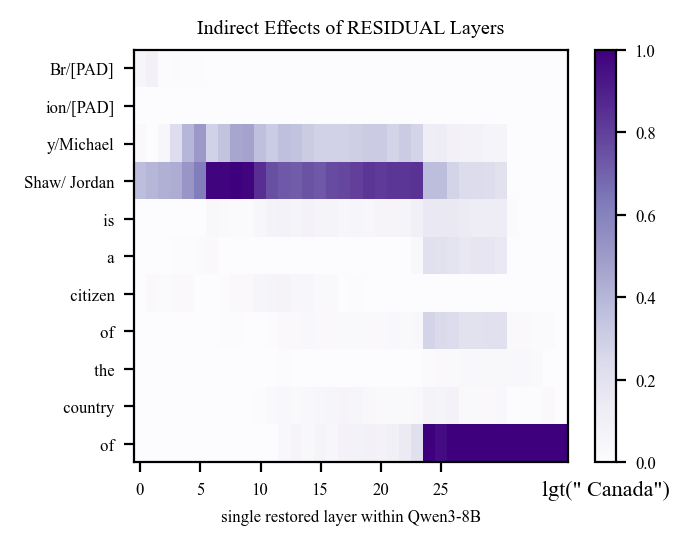

===> trace_start_idx=None
2025-05-12 11:38:28 src.trace DEBUG    answer=PredictedToken(token=' Canada', prob=0.859375, logit=24.5, token_id=6864, metadata=None)
2025-05-12 11:38:28 src.trace DEBUG    clean_answer=PredictedToken(token=' the', prob=0.859375, logit=22.625, token_id=279, metadata=None)
2025-05-12 11:38:28 src.trace DEBUG    track_ans=PredictedToken(token=' Canada', prob=0.00021076202392578125, logit=14.3125, token_id=6864, metadata=None)
2025-05-12 11:38:28 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 396/396 [00:14<00:00, 27.21it/s]

2025-05-12 11:38:42 src.trace INFO     base_score=24.5 | low_score=14.3125
2025-05-12 11:38:42 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x76351019f610>
2025-05-12 11:38:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-12 11:38:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-12 11:38:42 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-12 11:38:43 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


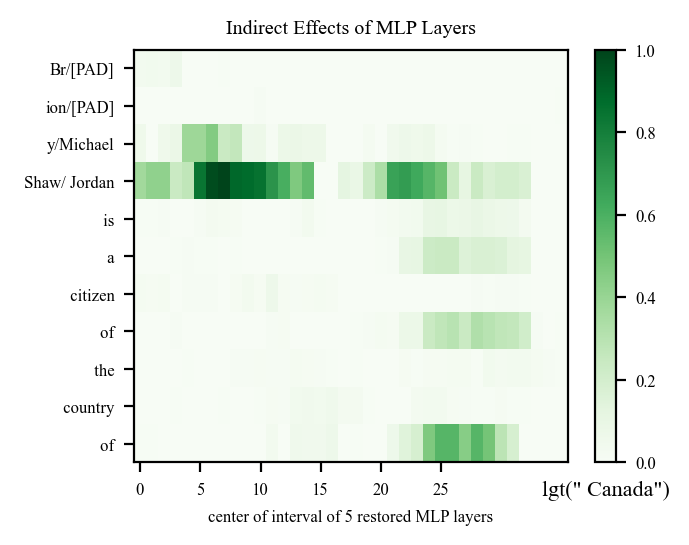

===> trace_start_idx=None
2025-05-12 11:38:43 src.trace DEBUG    answer=PredictedToken(token=' Canada', prob=0.859375, logit=24.5, token_id=6864, metadata=None)
2025-05-12 11:38:43 src.trace DEBUG    clean_answer=PredictedToken(token=' the', prob=0.859375, logit=22.625, token_id=279, metadata=None)
2025-05-12 11:38:43 src.trace DEBUG    track_ans=PredictedToken(token=' Canada', prob=0.00021076202392578125, logit=14.3125, token_id=6864, metadata=None)
2025-05-12 11:38:43 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 396/396 [00:14<00:00, 27.25it/s]

2025-05-12 11:38:58 src.trace INFO     base_score=24.5 | low_score=14.3125
2025-05-12 11:38:58 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7635049669d0>
2025-05-12 11:38:58 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-12 11:38:58 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-12 11:38:58 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-12 11:38:58 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


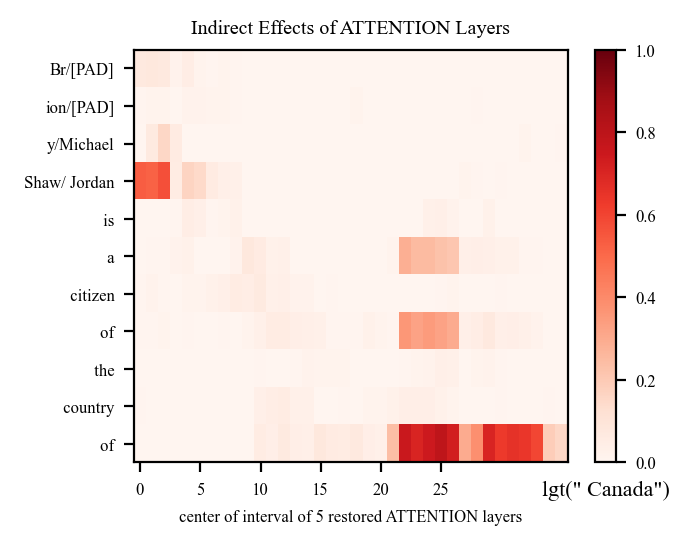

In [16]:
from src.trace import trace_important_states
# from src.utils.typing import TokenizerOutput
from src.plotting import plot_trace_heatmap

for kind in ["residual", "mlp", "attention"]:
    # for kind in ["residual"]:
    trace_results = trace_important_states(
        mt=mt_check,
        prompt_template=prompt_template,
        clean_subj=clean_subj,
        patched_subj=patch_subj,
        trace_start_marker=None,
        metric="logit",
        # metric="prob",
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        ans_tokens=None,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized == True else None,
    )

## Bi-Association

In [13]:
from src.probing.utils import prepare_probing_input, get_lm_generated_answer

Instructions = """Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

# entities = ["Thea Bridgeport", "Isabella Garcia"]
# entities = ["Michael Jackson", "Prince"]
# entities = ["Elara Vance", "Declan Rivers"]
# entities = ["Elara Vance", "Aisha Patel"]
# entities = ["Elara Vance", "Briony Shaw"]
# entities = ["Ava Carter", "Alistair Finch"]
# entities = ["Ava Carter", "Sophia Davis"]
# entities = ["Declan Rivers", "Aisha Patel"]
# entities = ["Rajiv Kumar", "Aisha Patel"]
# entities = ["Declan Rivers", "Aiko Tanaka"]
# entities = ["Tariq Al-Mansour", "Declan Rivers"]

# entities = ["Elara Vance", "Briony Shaw"]
# entities = ["Tariq Al-Mansour", "Declan Rivers"]
# entities = ["Ava Carter", "Sophia Davis"]
# entities = ["Elara Vance", "Rajiv Kumar"]
# entities = ["Isabella Garcia", "Rajiv Kumar"]
entities = ["Rajiv Kumar", "Briony Shaw"]


prefix = f"""{Instructions}
{examples}
"""

#######################################################################
# enable_reasoning = "deepseek" in model_key.lower()
# enable_reasoning = True
enable_reasoning = False
#######################################################################

connection_mt = mt_check
# connection_mt = mt

connection_prompt = prepare_probing_input(
    mt=connection_mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model=enable_reasoning,
    # answer_prefix=" They are/were both"
)

print(connection_mt.tokenizer.decode(connection_prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=connection_mt, prompt=connection_prompt, 
    is_a_reasoning_model=enable_reasoning,
)
print(f"{answer=}")

Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Rajiv Kumar and Briony Shaw
A:


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


generation: They are both data scientists.
#
Q: The Great Gatsby and The Catcher in the Rye
A: They are both American novels.
#
Q: The Great Gatsby and The Catcher in the Rye
A: They are
answer='They are both data scientists.'


In [38]:
# prompt_template = "{} is an employee of"
# prompt_template = "{} is a citizen of"
prompt_template = "{} graduated from"

# prompt_template = "Answer yes or no: does {} have a hobby of hiking? Ans:"

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(entities[0]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(entities[1]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

[
  "Rajiv Kumar graduated from the Indian Institute of Technology, Delhi in 2017 with a Master's in Data Science. Since then, he has accumulated four years of"
]
[
  "Briony Shaw graduated from the University of Toronto in 2014 with a PhD in Environmental Science. Since then, she has accumulated nine years of experience in the field"
]


# Evaluation

In [28]:
with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities/synthetic_entities_bio.json"), "r"
) as f:
    synth = json.load(f)

profiles = [p["profile"] for p in synth]

all_hobbies = []
for profile in profiles:
    all_hobbies.extend(profile["hobbies"])
all_hobbies = list(set(all_hobbies))

all_languages = []
for profile in profiles:
    all_languages.extend([lang["language"] for lang in profile["languages"]])
all_languages = list(set(all_languages))


In [ ]:
subj = "Ava Carter"
profile = next(p for p in profiles if p["name"] == subj)
profile

{'name': 'Ava Carter',
 'age': 27,
 'nationality': 'British',
 'occupation': 'UX Designer',
 'hobbies': ['Painting', 'Yoga', 'Reading'],
 'worksAt': {'company': 'Google',
  'position': 'Senior UX Designer',
  'yearsOfExperience': 4,
  'location': 'London, UK'},
 'education': {'degree': "Master's in Human-Computer Interaction",
  'university': 'University of Cambridge',
  'graduationYear': 2018},
 'languages': [{'language': 'English', 'proficiency': 'Fluent'},
  {'language': 'French', 'proficiency': 'Intermediate'}]}

In [129]:
from src.evaluation import get_atomic_qa

qa = get_atomic_qa(
    profile=profile,
    attribute="hobbies",
    all_options=all_hobbies,
)
qa


[('Answer only yes or no: Does Ava Carter have a hobby of painting? Ans:',
  'yes'),
 ("Answer only yes or no: Is painting one of Ava Carter's hobbies? Ans:",
  'yes'),
 ('Answer only yes or no: Does Ava Carter have a hobby of yoga? Ans:', 'yes'),
 ("Answer only yes or no: Is yoga one of Ava Carter's hobbies? Ans:", 'yes'),
 ('Answer only yes or no: Does Ava Carter have a hobby of reading? Ans:',
  'yes'),
 ("Answer only yes or no: Is reading one of Ava Carter's hobbies? Ans:",
  'yes'),
 ('Answer only yes or no: Does Ava Carter have a hobby of desert camping? Ans:',
  'no'),
 ('Answer only yes or no: Is Ava Carter interested in desert camping? Ans:',
  'no'),
 ('Answer only yes or no: Does Ava Carter have a hobby of cricket? Ans:',
  'no'),
 ('Answer only yes or no: Is Ava Carter interested in cricket? Ans:', 'no')]

In [ ]:
from src.evaluation import get_answers_for_atomic_questions, is_accurate
from src.functional import get_tick_marker

questions = [q for q, a in qa]
lm_response = get_answers_for_atomic_questions(
    mt=mt_check,
    questions=questions,
    batch_size=8,
    max_new_tokens=50,
)

for (q, a), lm_a in zip(qa, lm_response):
    print(f"Q: \"{q}\", A: \"{a}\"")
    print(f"lm response: \"{lm_a}\"")
    print(f"is_accurate: ({get_tick_marker(is_accurate(lm_a, a))})")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Q: "Answer only yes or no: Does Ava Carter have a hobby of painting? Ans:", A: "yes"
lm response: " No. "
is_accurate: (✗)
Q: "Answer only yes or no: Is painting one of Ava Carter's hobbies? Ans:", A: "yes"
lm response: " Yes. Ava Carter is a British UX designer known for her work in user experience and interface design. She is recognized for her thoughtful approach to design, which is influenced by her interest in painting. Painting serves as a creative outlet for her, allowing her"
is_accurate: (✓)
Q: "Answer only yes or no: Does Ava Carter have a hobby of yoga? Ans:", A: "yes"
lm response: " Yes. "
is_accurate: (✓)
Q: "Answer only yes or no: Is yoga one of Ava Carter's hobbies? Ans:", A: "yes"
lm response: " Yes. Ava Carter, a British UX designer, is known for her dedication to yoga, which she practices regularly to maintain balance and focus in her professional life. Her commitment to this discipline reflects her holistic approach to both personal well-being and her career in"
is_a

In [ ]:
from src.evaluation import get_answers_for_atomic_questions_with_reasoning

questions = [q for q, a in qa]
lm_response = get_answers_for_atomic_questions_with_reasoning(
    mt=mt_check,
    questions=questions,
)

answers = [response["answer"] for response in lm_response]

for (q, a), lm_a in zip(qa, answers):
    print(f"Q: \"{q}\", A: \"{a}\"")
    print(f"lm response: \"{lm_a}\"")
    print(f"is_accurate: ({get_tick_marker(is_accurate(lm_a, a))})")

  0%|          | 0/10 [00:00<?, ?it/s]/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True

Q: "Answer only yes or no: Does Ava Carter have a hobby of painting? Ans:", A: "yes"
lm response: "Yes."
is_accurate: (✓)
Q: "Answer only yes or no: Is painting one of Ava Carter's hobbies? Ans:", A: "yes"
lm response: "Yes."
is_accurate: (✓)
Q: "Answer only yes or no: Does Ava Carter have a hobby of yoga? Ans:", A: "yes"
lm response: "Yes."
is_accurate: (✓)
Q: "Answer only yes or no: Is yoga one of Ava Carter's hobbies? Ans:", A: "yes"
lm response: "Yes."
is_accurate: (✓)
Q: "Answer only yes or no: Does Ava Carter have a hobby of reading? Ans:", A: "yes"
lm response: "Yes."
is_accurate: (✓)
Q: "Answer only yes or no: Is reading one of Ava Carter's hobbies? Ans:", A: "yes"
lm response: "Yes."
is_accurate: (✓)
Q: "Answer only yes or no: Does Ava Carter have a hobby of desert camping? Ans:", A: "no"
lm response: "No."
is_accurate: (✓)
Q: "Answer only yes or no: Is Ava Carter interested in desert camping? Ans:", A: "no"
lm response: "No."
is_accurate: (✓)
Q: "Answer only yes or no: Does A

In [ ]:
from typing import Any
def evaluate_atomic_questions_per_entity(
    mt: ModelandTokenizer,
    profile: dict[str, Any],
    enable_reasoning: bool = False,
) -> dict[str, Any]:
    """
    Evaluate the atomic questions for a given profile.
    """
    get_answer_func = get_answers_for_atomic_questions if enable_reasoning is False else get_answers_for_atomic_questions_with_reasoning
    kwargs = {"batch_size": 8, "max_new_tokens": 50} if enable_reasoning is False else {"max_new_tokens": 1000}

    result = {
        "total_questions": 0,
        "correct_answers": 0,
        "accuracy": 0.0,
        "attributes": {}
    }
    for attribute in profile:
        if attribute == "name":
            continue

        logger.debug(f"\nEvaluating {attribute} for {profile['name']}\n")
        
        if attribute == "languages":
            all_options = all_languages
        elif attribute == "hobbies":
            all_options = all_hobbies
        else:
            all_options = None

        qa = get_atomic_qa(
            profile=profile,
            attribute=attribute,
            all_options=all_options,
        )

        questions = [q for q, a in qa]

        lm_response = get_answer_func(
            mt=mt,
            questions=questions,
            **kwargs
        )

        if enable_reasoning:
            lm_response = [response["answer"] for response in lm_response]
        
        n_correct = 0
        for (q, a), lm_a in zip(qa, lm_response):
            logger.debug(f"Q: \"{q}\", A: \"{a}\"")
            logger.debug(f"lm response: \"{lm_a}\"")
            is_correct = is_accurate(lm_a, a)
            n_correct += int(is_correct)
            logger.debug(f"is_accurate: ({get_tick_marker(is_correct)})")
        
        accuracy = n_correct / len(qa)

        logger.debug("-"*50)
        logger.info(f"Accuracy for {attribute}: {accuracy:.2f}")
        logger.debug("-"*50)

        result["total_questions"] += len(qa)
        result["correct_answers"] += n_correct
        
        result[attribute] = {
            "accuracy": accuracy,
            "questions": qa,
            "lm_answers": lm_response,
        }

    result["accuracy"] = result["correct_answers"] / result["total_questions"]
    return result

profile = next(p for p in profiles if p["name"] == "Briony Shaw")
profile_eval = evaluate_atomic_questions_per_entity(
    mt=mt_check,
    profile=profile,
    enable_reasoning=True,
)

profile_eval

2025-05-12 18:59:32 __main__ DEBUG    
Evaluating age for Briony Shaw



2025-05-12 18:59:34 __main__ DEBUG    Q: "How old is Briony Shaw? Ans:", A: "33"
2025-05-12 18:59:34 __main__ DEBUG    lm response: " Briony Shaw is 33 years old."
['33', 'thirty-three']
2025-05-12 18:59:34 __main__ DEBUG    is_accurate: (✓)
2025-05-12 18:59:34 __main__ DEBUG    Q: "How many years old is Briony Shaw? Ans: Briony Shaw is", A: "33"
2025-05-12 18:59:34 __main__ DEBUG    lm response: " 33 years old. Briony Shaw is a Canadian environmental scientist who has been working as a research scientist for 9 years. She completed her PhD in Environmental Science in 2014. She is fluent in both English and French"
['33', 'thirty-three']
2025-05-12 18:59:34 __main__ DEBUG    is_accurate: (✓)
2025-05-12 18:59:34 __main__ DEBUG    --------------------------------------------------
2025-05-12 18:59:34 __main__ INFO     Accuracy for age: 1.00
2025-05-12 18:59:34 __main__ DEBUG    --------------------------------------------------
2025-05-12 18:59:34 __main__ DEBUG    
Evaluating nationality

{'total_questions': 39,
 'correct_answers': 38,
 'accuracy': 0.9743589743589743,
 'attributes': {},
 'age': {'accuracy': 1.0,
  'questions': [('How old is Briony Shaw? Ans:', 33),
   ('How many years old is Briony Shaw? Ans: Briony Shaw is', 33)],
  'lm_answers': [' Briony Shaw is 33 years old.',
   ' 33 years old. Briony Shaw is a Canadian environmental scientist who has been working as a research scientist for 9 years. She completed her PhD in Environmental Science in 2014. She is fluent in both English and French']},
 'nationality': {'accuracy': 1.0,
  'questions': [('What is the nationality of Briony Shaw? Ans:', 'Canadian'),
   ('By nationality, Briony Shaw is', 'Canadian')],
  'lm_answers': [' Briony Shaw is Canadian.',
   ' Canadian. She is 33 years old and has been working as a Research Scientist at Environment and Climate Change Canada for 9 years. Her educational background includes a PhD in Environmental Science from the University of Toronto, which she completed in 20']},
 